.benchmarks/Darwin-CPython-3.11-64bit/0003_a7f9e06fd44a98dc1caf03c110caf57e8dbf69c3_20231221_103807_uncommited-changes.json
benchmark results
  2023-12-21T10:48:12.673733
  Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz

UnbinnedNLL
UnbinnedNLL_log
nll_numba_stats
nll_scipy.stats
nll_numba
minuit
minuit_numba
minuit_log
minuit_log_numba
minuit_parallel_fastmath
minuit_parallel_fastmath_log
minuit_cfunc
minuit_UnbinnedNLL
minuit_UnbinnedNLL_log
RooFit_legacy
RooFit_legacy-parallel
RooFit_cpu
RooFit_cpu-parallel
RooFit_cpu-implicitmt
RooFit_codegen
RooFit_codegen_no_grad


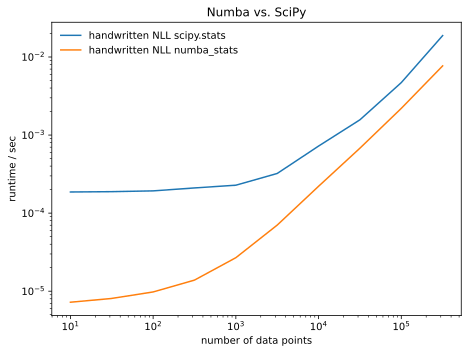

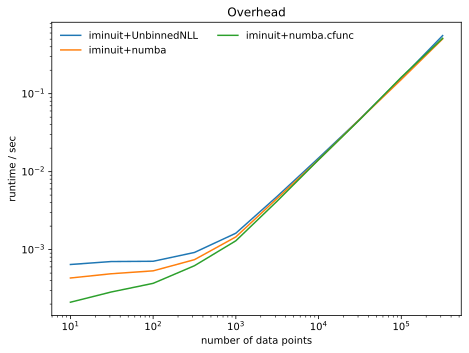

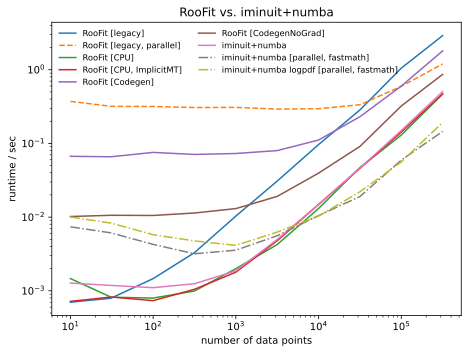

In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_formats = ['svg']


with open("root.json") as f:
    root_data = json.load(f)

paths = []
for p in Path(".benchmarks").rglob("*.json"):
    paths.append((p.stat().st_mtime, p))
paths.sort()
fn = paths[-1][1]

print(fn)
with open(fn) as f:
    data = json.load(f)

print(
    f"""\
benchmark results
  {data["datetime"]}
  {data["machine_info"]["cpu"]["brand_raw"]}
"""
)

variant = {}
for d in (data, root_data):
    # override ROOT results with root_data if any
    for k in tuple(variant):
        if k.startswith("RooFit"):
            del variant[k]
    for b in d["benchmarks"]:
        params = b["params"]
        n = params["n"]
        n = int(n)
        name = b["name"]
        name = name[name.find("_") + 1 : name.find("[")]
        extra = []
        for k, v in params.items():
            if k in ("n", "lib", "model"):
                continue
            if isinstance(v, (bool, int)):
                if v:
                    extra.append(k)
            else:
                extra.append(v)
        if extra:
            name += "_" + "_".join(extra)
        for key in ("lib", "model"):
            if key in params:
                name += f"_{params[key]}"
        t = b["stats"]["min"]
        if name not in variant:
            variant[name] = []
        variant[name].append((n, t))

for k in variant:
    print(k)

names = {
    "Numba vs. SciPy": {
        "nll_scipy.stats": "handwritten NLL scipy.stats",
        "nll_numba_stats": "handwritten NLL numba_stats",
    },
    "Overhead": {
        "minuit_UnbinnedNLL": "iminuit+UnbinnedNLL",
        "minuit_numba": "iminuit+numba",
        "minuit_cfunc": "iminuit+numba.cfunc",
    },
    "RooFit vs. iminuit+numba": {
        "RooFit_legacy": "RooFit [legacy]",
        "RooFit_legacy-parallel": "RooFit [legacy, parallel]",
        "RooFit_cpu": "RooFit [CPU]",
        "RooFit_cpu-implicitmt": "RooFit [CPU, ImplicitMT]",
        # "RooFit_cpu_NumCPU": "RooFit [CPU, parallel]",
        "RooFit_codegen": "RooFit [Codegen]",
        "RooFit_codegen_no_grad": "RooFit [CodegenNoGrad]",
        # "RooFit_codegen_NumCPU": "RooFit [Codegen, parallel]",
        "minuit": "iminuit+numba",
        "minuit_parallel_fastmath": "iminuit+numba [parallel, fastmath]",
        "minuit_parallel_fastmath_log": "iminuit+numba logpdf [parallel, fastmath]",
    },
}

for title, subnames in names.items():
    plt.figure(constrained_layout=True)
    plt.title(title)
    for name in subnames:
        if name not in variant:
            continue
        d = variant[name]
        n, t = np.transpose(d)
        ls = "-"
        if (
            "parallel" in name
            and "fastmath" in name
            or ("NumCPU" in name and "BatchMode" in name)
        ):
            ls = "-."
        elif "parallel" in name or "NumCPU" in name:
            ls = "--"
        elif "fastmath" in name or "BatchMode" in name:
            ls = ":"
        plt.plot(n, t, ls=ls, label=subnames[name])

    plt.loglog()
    plt.legend(
        frameon=False,
        fontsize="medium" if len(subnames) < 4 else "small",
        ncol=1 if len(subnames) < 3 else 2,
    )
    # plt.title("Fit of normal distribution with 2 parameters")
    plt.xlabel("number of data points")
    plt.ylabel("runtime / sec")
    fname = title.replace(" ", "_").replace(".", "_").replace("__", "_").lower()
    plt.savefig(f"{fname}.svg")